# Environment setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/MyDrive/Colab\ Notebooks/ECE219/Project\ 3

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/ECE219/Project 3


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
!!pip install lightgbm
!pip install scikit-surprise

In [ ]:
from surprise import Dataset, Reader
from surprise.model_selection import KFold, train_test_split
from surprise.prediction_algorithms.knns import KNNWithMeans
from surprise.prediction_algorithms.matrix_factorization import NMF, SVD
from surprise.similarities import pearson
from surprise.accuracy import rmse, mae

In [ ]:
from tqdm.auto import tqdm

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score, auc, mean_squared_error
from sklearn import model_selection

# Utils

In [ ]:
def trim(data_frame, mode):
    """
    It returns the trimmed subset of data_frame.
    """
    if mode == "popular":
        sub_df = data_frame.groupby("movieId").filter(lambda x: len(x) > 2)
    elif mode == "unpopular":
        sub_df = data_frame.groupby("movieId").filter(lambda x: len(x) <= 2)
    elif mode == "high-var":
        sub_df = data_frame.groupby("movieId").filter(lambda x: len(x) >= 5 and np.nanvar(x) >= 2)
    else:
        sub_df = data_frame
    return sub_df


def subset_test(data_frame, mode, ks, n_splits=10, rating_scale=(0.5, 5), filter="kNN"):
    """
    This function returns the average RMSEs and MAEs on the given ks, each average measure is computed using k-fold CV (default 10)
    - data_frame: the original data frame
    - mode: the trime mode indicating how data_frame will be trimmed
    - ks: different k's to be used for model construction
    - filter: different models to be used
    """
    # get the trimmed subset
    subset = trim(data_frame, mode)
    # convert the subset into a surprise dataset
    reader = Reader(rating_scale=rating_scale)
    sub_data = Dataset.load_from_df(subset[['userId', 'movieId', 'rating']], reader)
    # define a cross-validation iterator
    kf = KFold(n_splits=n_splits)

    # cross validate
    avg_RMSEs = []
    avg_MAEs = []
    for k in tqdm(ks):
        if filter == "NMF":
            curr_filter = NMF(n_factors=k)          # unbiased
        elif filter == "MF-bias":
            curr_filter = SVD(n_factors=k)          # biased
        else:
            curr_filter = KNNWithMeans(k=k, sim_options={"name": "pearson", "user_based": True}, verbose=False)
        curr_RMSE = []          # record the RMSE on the current k-fold cross-validation
        curr_MAE = []
        for train, val in kf.split(sub_data):
            curr_filter.fit(train)
            preds = curr_filter.test(val)
            curr_RMSE.append(rmse(preds, verbose=False))
            curr_MAE.append(mae(preds, verbose=False))
        avg_RMSEs.append(sum(curr_RMSE) / len(curr_RMSE))
        avg_MAEs.append(sum(curr_MAE) / len(curr_MAE))
    return avg_RMSEs, avg_MAEs


def subset_naive(data_frame, mode, n_splits=10):
    """
    This function is a special case of subset_test, as it uses the naive predictor (mean rating of a user for any thing).
    """
    # get the trimmed subset
    subset = trim(data_frame, mode)
    # define a k-fold iterator
    kf = model_selection.KFold(n_splits=n_splits)

    # for naive method, we obtain the mean before CV
    user_mean_ratings = subset.groupby('userId')['rating'].mean().to_dict()

    # cross validate
    RMSEs = []
    for train_idx, val_idx in kf.split(subset):
        # obtain the validation pairs
        val = subset.iloc[val_idx]
        val_preds = val["userId"].map(user_mean_ratings).fillna(0)
        val_ratings = val["rating"]
        RMSEs.append(mean_squared_error(val_ratings, val_preds, squared=False))
    return sum(RMSEs) / len(RMSEs)

In [ ]:
def plot_pesudo_ROC(data_frame, thresholds, trim_modes, optimal_ks, model_type="kNN"):
    """
    This function plots the pseudo-ROC of the model_type model that fits and tests on the trimmed subset.
    - data_frame: the original data frame for processing
    - thresholds: a list of thresholds that binarize the true labels only
    - trim_modes: a list of trim modes that describe how to trim the data_frame
    - optimal_ks: a dict of (trim_mode, trim_optimal_k)
    - model_type: the model to use
    """
    plt.figure(figsize=(6 * len(trim_modes), 6))
    for i in range(len(trim_modes)):
        # get the trimmed subset
        trim_mode = trim_modes[i]
        curr_subset = trim(data_frame, trim_mode)
        # convert the subset into a surprise dataset
        curr_data = Dataset.load_from_df(curr_subset[['userId', 'movieId', 'rating']], Reader(rating_scale=(0.5, 5)))
        # split into 90% training and 10% validation
        train, val = train_test_split(curr_data, test_size=0.1)

        # choose the model to use
        if model_type == "NMF":
            model = NMF(n_factors=optimal_ks[trim_mode])
        elif model_type == "MF-bias":
            model = SVD(n_factors=optimal_ks[trim_mode])
        else:
            model = KNNWithMeans(k=optimal_ks[trim_mode], sim_options={"name": "pearson", "user_based": True}, verbose=False)

        # train the knn model
        model.fit(train)
        # test on the validation subset
        preds = model.test(val)

        plt.subplot(1, len(trim_modes), i+1)
        for j in range(len(thresholds)):
            curr_threshold = thresholds[j]
            # collect the predicted and true labels after binarization by the threshold
            true_ratings = [1 if pred.r_ui > curr_threshold else 0 for pred in preds]
            pred_ratings = [pred.est for pred in preds]                 # directly use the estimated score
            # compute the fpr and tpr
            fpr, tpr, _ = roc_curve(true_ratings, pred_ratings)
            roc_auc = auc(fpr,tpr)
            plt.plot(fpr, tpr, lw=2, label="AUC = {:.3f} with threshold {}".format(roc_auc, curr_threshold))

        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.grid(color='0.7', linestyle='--', linewidth=1)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"ROCs on {trim_mode} dataset")
        plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()

# Dataset

In [ ]:
data_frame = pd.read_csv("movie_data/ratings.csv")
data = data_frame.pivot(index='userId', columns='movieId', values='rating').to_numpy()

## Sparsity

In [ ]:
num_ratings = np.sum(np.where(np.isnan(data), 0, 1))
num_entries = data.shape[0] * data.shape[1]
sparsity = num_ratings / num_entries
print(f"The sparsity of the data matrix is {sparsity}.")

The sparsity of the data matrix is 0.016999683055613623.


## Frequency of the rating values

In [ ]:
valid_data = data[~np.isnan(data)]
bins = np.arange(np.min(valid_data), np.max(valid_data) + 1, 0.5)
counts, bin_edges = np.histogram(valid_data, bins=bins)

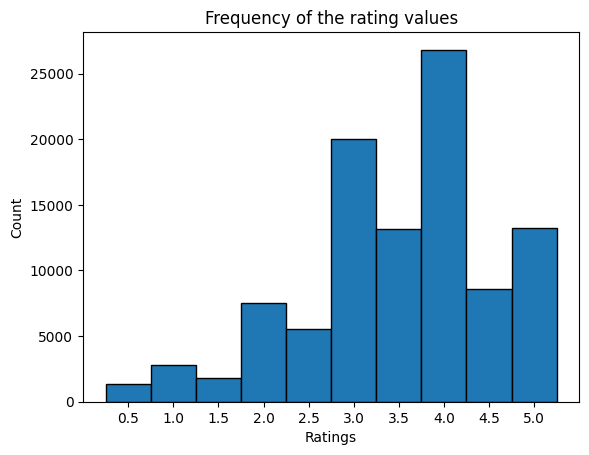

In [ ]:
plt.hist(bin_edges[:-1], bin_edges, weights=counts, align="left", edgecolor="k")
plt.xlabel('Ratings')
plt.ylabel('Count')
plt.title('Frequency of the rating values')
plt.xticks(bin_edges[:-1])
plt.show()

The histogram showed that the users are most often to give 3.0 and 4.0, while giving a small number of very low ratings between 0.5 and 1.5.

## Distribution of ratings among movies 

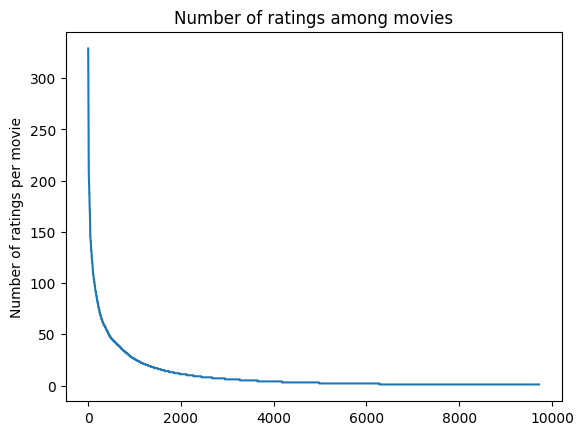

In [ ]:
rating_num_per_movie = np.sum(np.where(np.isnan(data), 0, 1), axis=0)
decrease_num_ratings_movies = np.sort(rating_num_per_movie)[::-1]
plt.plot(np.arange(0, len(decrease_num_ratings_movies)), decrease_num_ratings_movies)
plt.ylabel('Number of ratings per movie')
plt.title('Number of ratings among movies')
plt.show()

## Distribution of ratings among users

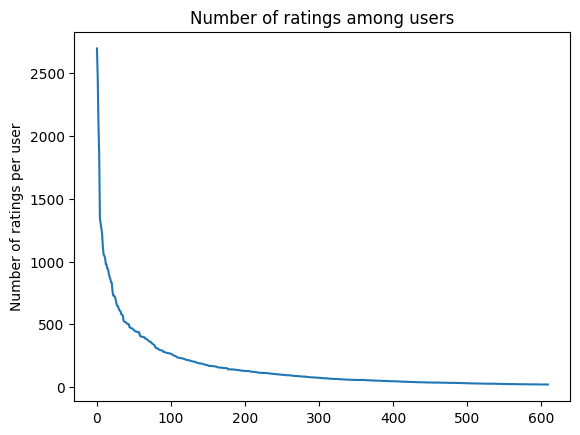

In [ ]:
rating_num_per_user = np.sum(np.where(np.isnan(data), 0, 1), axis=1)
decrease_num_ratings_users = np.sort(rating_num_per_user)[::-1]
plt.plot(np.arange(0, len(decrease_num_ratings_users)), decrease_num_ratings_users)
plt.ylabel('Number of ratings per user')
plt.title('Number of ratings among users')
plt.show()

## Salient features of distributions

The distributions above showed that the ratings per move and per user are both long-skewed, as only a small fraction of moves and users have a high number of corresponding ratings. Such a feature can make the data martix very sparse, and those movies and users with a relatively large number of ratings may carry more weights in the recommendation process.

## Rating variances of movies

In [ ]:
movie_rating_vars = np.nanvar(data, axis=0)
movie_rating_vars_bins = np.arange(np.min(movie_rating_vars), np.max(movie_rating_vars) + 1, 0.5)
var_counts, var_bin_edges = np.histogram(movie_rating_vars, bins=movie_rating_vars_bins)

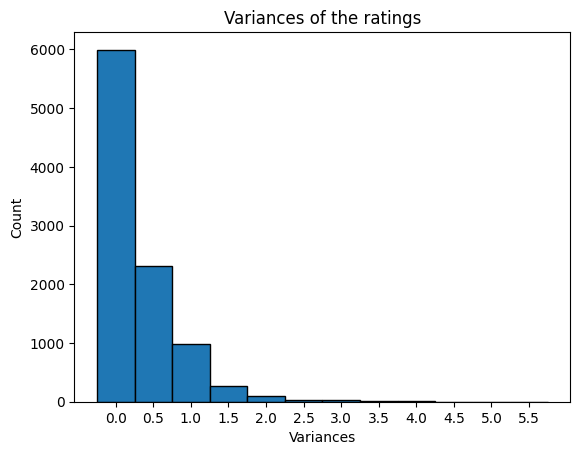

In [ ]:
plt.hist(var_bin_edges[:-1], var_bin_edges, weights=var_counts, align="left", edgecolor="k")
plt.xlabel('Variances')
plt.ylabel('Count')
plt.title('Variances of the ratings')
plt.xticks(var_bin_edges[:-1])
plt.show()

We could see that most of movies have ratings of low variances, meaning that users have somewhat consensus on the rating for the same movie with some exceptions.

# User-based collaborative filtering

## Pearson-correlation coefficient

$$\mu_u = \frac{1}{|I_u|}\sum_{k\in I_u} r_{uk}$$

$I_u\cap I_v$ means the set of item indices for which ratings have been specified by both users $u, v$. By definition, it could be an empty set, in which case the given two users have never rated the same movie, and their correlation coefficient is 0.

## Prediction function: centering

The prediction is made based on the mean rating of the target user and the similar users' rating variation for the target item. The mean-centering is to measure, for a similar user $v$, how far its rating $r_{vj}$ is from its mean rating $\mu_v$. This measure can be interpreted as the preference of this similar user on the target item compared with average.

For example, the movie $j$ is the target movie, and there exist two similar users $a, b$ in the neighbourhood of our target user. User $a$ rated all the watched movies highly, and he rated movie $j$ 0.5 above his average rating. User $b$ rated all the watched movies poorly, but she also rated movie $j$ 0.5 higher above her average rating. In this case, both users $a, b$ should contribute to the prediction equally according to the pearson-coefficients as they both prefer this moive above their own average. Without mean-centering, the predicted rating $\hat{r}_{uj}$ will be heavily biased towards the users with average high ratings.




## k-NN filter 

In [ ]:
knn_ks = [k for k in range(2, 102, 2)]

  0%|          | 0/50 [00:00<?, ?it/s]

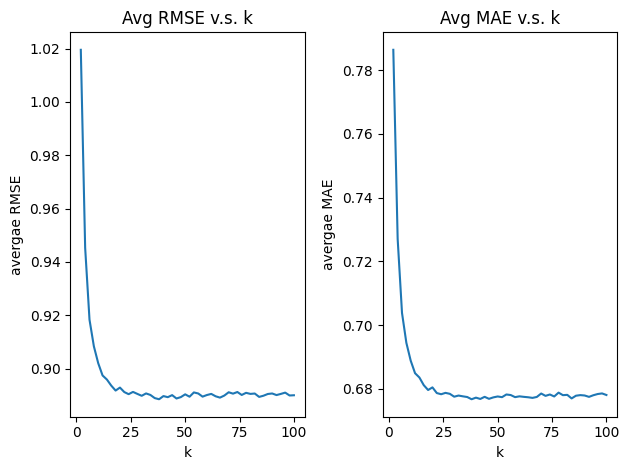

In [ ]:
avg_RMSEs_knn_full, avg_MAEs_knn_full = subset_test(data_frame, "full", knn_ks)

# plot the KNN on full dataset
plt.subplot(1, 2, 1)
plt.plot(knn_ks, avg_RMSEs_knn_full)
plt.xlabel("k")
plt.ylabel("avergae RMSE")
plt.title("Avg RMSE v.s. k")

plt.subplot(1, 2, 2)
plt.plot(knn_ks, avg_MAEs_knn_full)
plt.xlabel("k")
plt.ylabel("avergae MAE")
plt.title("Avg MAE v.s. k")

plt.tight_layout()
plt.show()

## Minimum k for k-NN 

Based on the plot above, the minimum k should be 26.
- The steady state value of average RMSE is 0.89
- The steady state value of average MAE is 0.68

## Predict on subsets 

In this part, we test the performance of k-NN filters on some specific subsets of the dataset. In particular, we have types:
- "popular": received more than 2 ratings
- "unpopular": only received less than or equal to 2 ratings
- "high-var": have variance (of the rating values received) of at least 2 and have received at least 5 ratings

  0%|          | 0/50 [00:00<?, ?it/s]

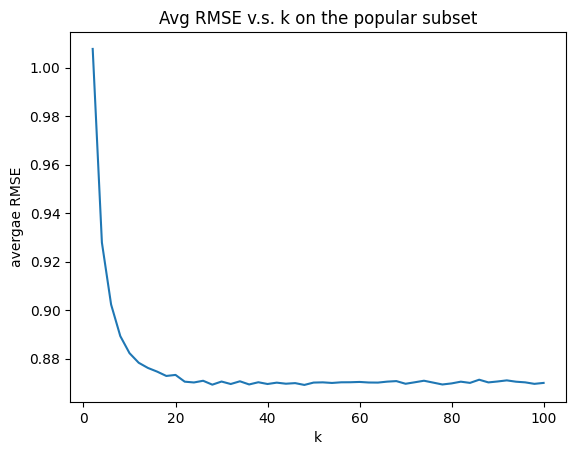

The minimum average RMSE using kNN on the popular subset is 0.8692117947488347 at k=48


In [ ]:
# popular subset
avg_RMSEs_knn_popular, _ = subset_test(data_frame, "popular", knn_ks)
min_RMSE_knn_popular = min(avg_RMSEs_knn_popular)
min_RMSE_knn_popular_k = knn_ks[avg_RMSEs_knn_popular.index(min_RMSE_knn_popular)]

plt.plot(knn_ks, avg_RMSEs_knn_popular)
plt.xlabel("k")
plt.ylabel("avergae RMSE")
plt.title("Avg RMSE v.s. k on the popular subset")
plt.show()

print(f"The minimum average RMSE using kNN on the popular subset is {min_RMSE_knn_popular} at k={min_RMSE_knn_popular_k}")

  0%|          | 0/50 [00:00<?, ?it/s]

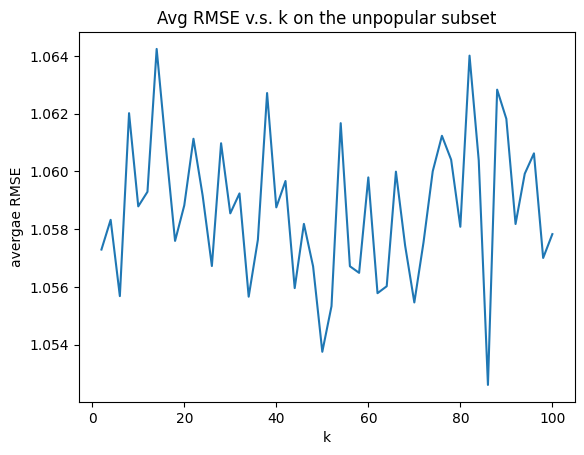

The minimum average RMSE using kNN on the unpopular subset is 1.0526068083704367 at k=86


In [ ]:
# unpopular subset
avg_RMSEs_knn_unpopular, _ = subset_test(data_frame, "unpopular", knn_ks)
min_RMSE_knn_unpopular = min(avg_RMSEs_knn_unpopular)
min_RMSE_knn_unpopular_k = knn_ks[avg_RMSEs_knn_unpopular.index(min_RMSE_knn_unpopular)]

plt.plot(knn_ks, avg_RMSEs_knn_unpopular)
plt.xlabel("k")
plt.ylabel("avergae RMSE")
plt.title("Avg RMSE v.s. k on the unpopular subset")
plt.show()

print(f"The minimum average RMSE using kNN on the unpopular subset is {min_RMSE_knn_unpopular} at k={min_RMSE_knn_unpopular_k}")

  0%|          | 0/50 [00:00<?, ?it/s]

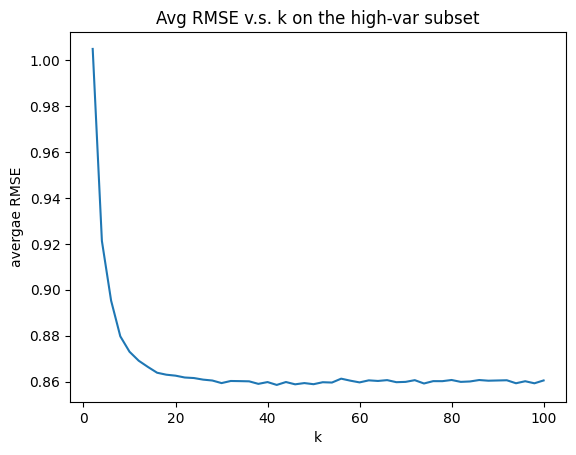

The minimum average RMSE using kNN on the unpopular subset is 0.858626290686877 at k=42


In [ ]:
# high-var subset
avg_RMSEs_knn_highvar, _ = subset_test(data_frame, "high-var", knn_ks)
min_RMSE_knn_highvar = min(avg_RMSEs_knn_highvar)
min_RMSE_knn_highvar_k = knn_ks[avg_RMSEs_knn_highvar.index(min_RMSE_knn_highvar)]

plt.plot(knn_ks, avg_RMSEs_knn_highvar)
plt.xlabel("k")
plt.ylabel("avergae RMSE")
plt.title("Avg RMSE v.s. k on the high-var subset")
plt.show()

print(f"The minimum average RMSE using kNN on the unpopular subset is {min_RMSE_knn_highvar} at k={min_RMSE_knn_highvar_k}")

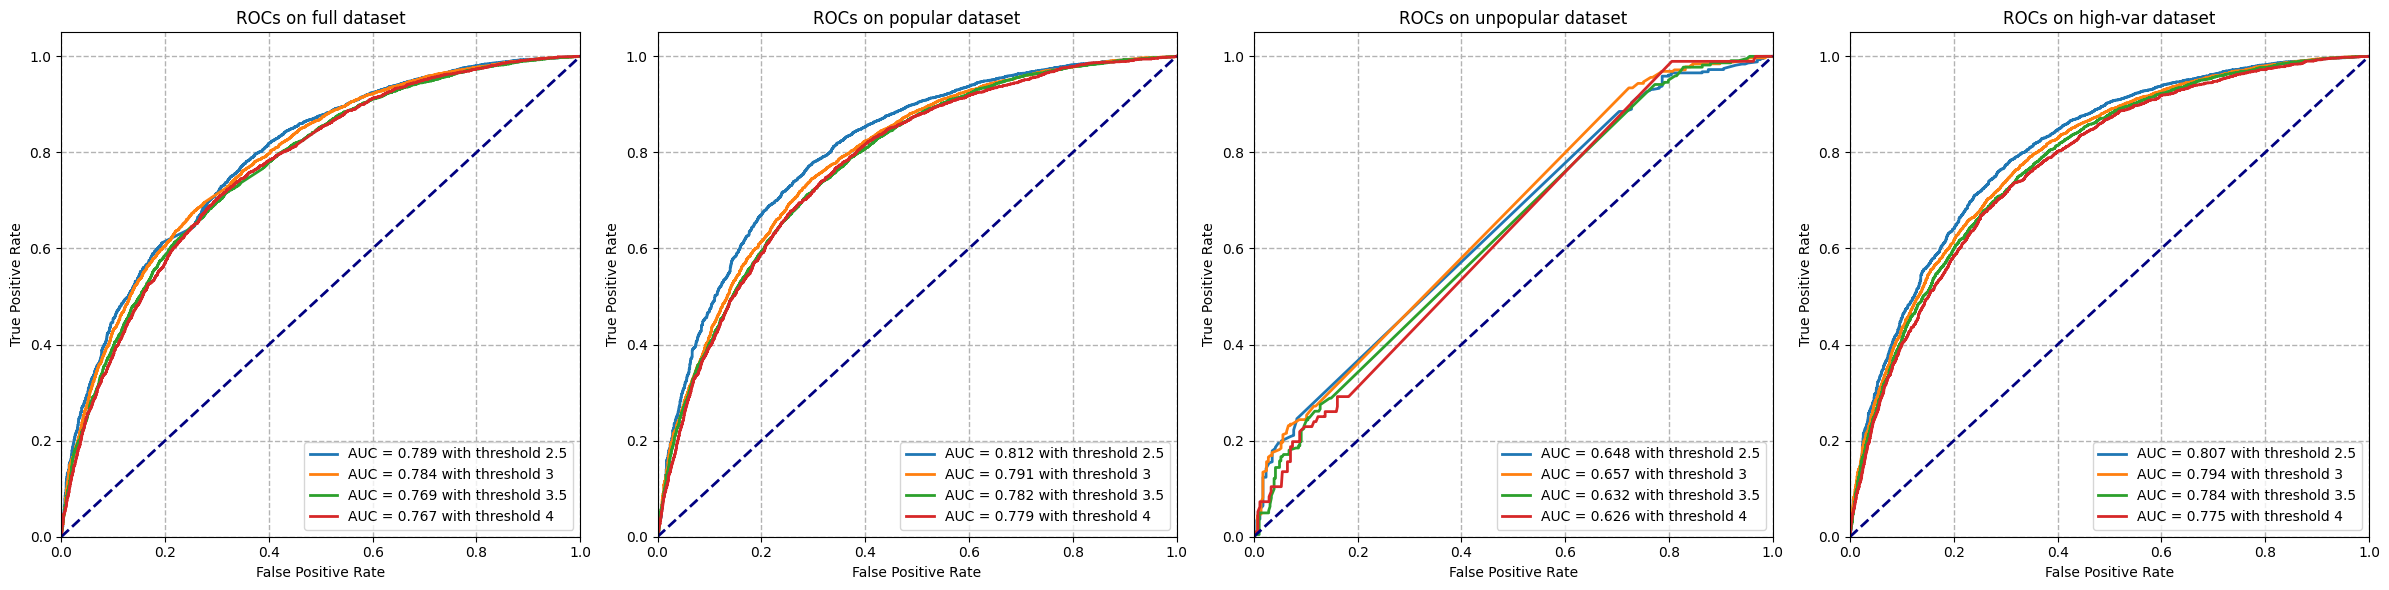

In [ ]:
# plot the ROC
trim_modes = ["full", "popular", "unpopular", "high-var"]
knn_thresholds = [2.5, 3, 3.5, 4]

optimal_knn_ks = {
    "full": 24,
    "popular": 40,
    "unpopular": 50,
    "high-var": 40
}           # these values are picked as the optimal instead of minimum k for the results above

plot_pesudo_ROC(data_frame, knn_thresholds, trim_modes, optimal_knn_ks, "kNN")

# Latent Factor Model

## Cost function analysis

The problem in equation 5 is **not convex** as it involves the product of two variable matrices.

Suppose $U$ is fixed, the problem can be reformulated as $$\min_V ||W\circ R - W\circ UV^\top||_F^2$$

then the problem becomes
$$\underset{V}{\text{minimize}} \hspace{2ex} \sum_{i=1}^m \sum_{j=1}^n W_{ij}(r_{ij} - (UV^\top)_{ij})^2$$

Denote
- $U_i$ is the i-th row of user matrix $U$,
- $V_j$ is the j-th row of item matrix $V$,
- $W_k$ is the k-th column of the indicator matrix $W$,
- $R_r$ is the r-th column of the rating matrix $R$,

we have
$$\begin{aligned}
L(V) &= \sum_{j=1}^n W_j\circ (R_j - UV_j^\top)^\top (R_j - UV_j^\top)\\
&= \sum_{j=1}^n W_j\circ (R_j^\top R_j - 2R_j^\top UV_j^\top + V_jU^\top U V_j^\top)\\
\frac{\partial L(V)}{\partial V_j} &= -2W_j\circ R_j^\top U + 2W_j\circ V_j U^\top U = 0\\
W_j \circ R_j^\top U &=  W_j\circ V_j U^\top U\\
W_j \circ V_j &= W_j \circ R_j^\top U(U^\top U)^{-1} \hspace{5ex} \text{we eliminate the mask matrix here as it is just an indicator}
\end{aligned}$$

That is, the solution $V^*$ needs to satisfy that (without considering the mask $W$)
$$V = R^\top U(U^\top U)^{-1}$$ as it is constrained only by the available ratings.

## NMF collaborative filter

### NMF over 10-fold cross-validation 

In [ ]:
nmf_ks = [k for k in range(2, 52, 2)]

  0%|          | 0/25 [00:00<?, ?it/s]

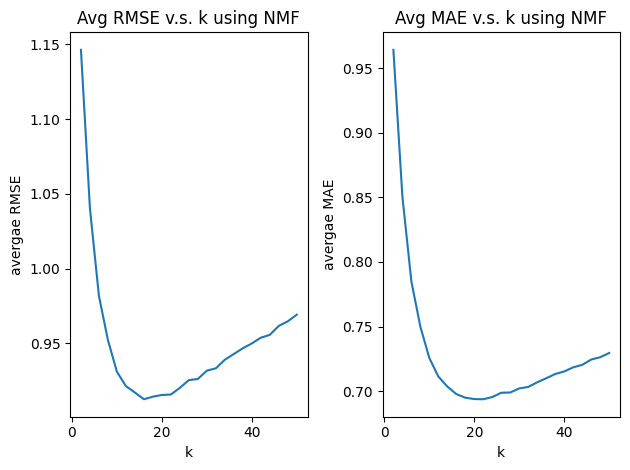

In [ ]:
avg_RMSEs_nmf_full, avg_MAEs_nmf_full = subset_test(data_frame, "full", nmf_ks, filter="NMF")

plt.subplot(1, 2, 1)
plt.plot(nmf_ks, avg_RMSEs_nmf_full)
plt.xlabel("k")
plt.ylabel("avergae RMSE")
plt.title("Avg RMSE v.s. k using NMF")

plt.subplot(1, 2, 2)
plt.plot(nmf_ks, avg_MAEs_nmf_full)
plt.xlabel("k")
plt.ylabel("avergae MAE")
plt.title("Avg MAE v.s. k using NMF")

plt.tight_layout()
plt.show()

### Optimal number of latent factors

In [ ]:
min_RMSE_nmf_full = min(avg_RMSEs_nmf_full)
min_RMSE_nmf_full_k = nmf_ks[avg_RMSEs_nmf_full.index(min_RMSE_nmf_full)]
print(f"Min average RMSE is {min_RMSE_nmf_full} when the number of factors is {min_RMSE_nmf_full_k}")

min_MAE_nmf_full = min(avg_MAEs_nmf_full)
min_MAE_nmf_full_k = nmf_ks[avg_MAEs_nmf_full.index(min_MAE_nmf_full)]
print(f"Min average MAE is {min_MAE_nmf_full} when the number of factors is {min_MAE_nmf_full_k}")

Min average RMSE is 0.9124552809782942 when the number of factors is 16
Min average MAE is 0.6937959076820084 when the number of factors is 22


The optimal k above should be 16 or 22, which is not the same as the number of movie genres, but very close to it (18).

### Trim subsets 

  0%|          | 0/25 [00:00<?, ?it/s]

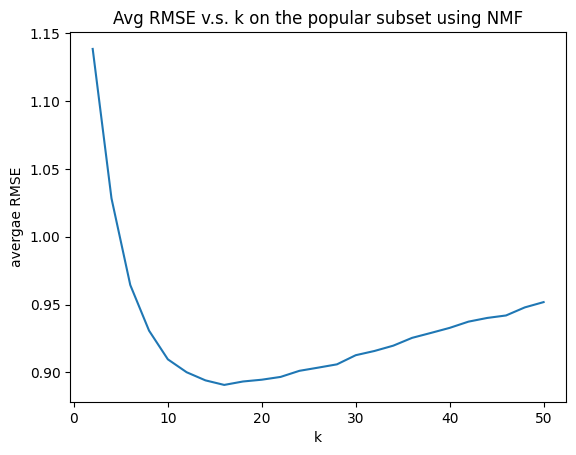

The minimum average RMSE for the popular subset is 0.8907043137872266 at k=16


In [ ]:
# popular subset
avg_RMSEs_nmf_popular, _ = subset_test(data_frame, "popular", nmf_ks, filter="NMF")
min_RMSE_nmf_popular = min(avg_RMSEs_nmf_popular)
min_RMSE_nmf_popular_k = nmf_ks[avg_RMSEs_nmf_popular.index(min_RMSE_nmf_popular)]

plt.plot(nmf_ks, avg_RMSEs_nmf_popular)
plt.xlabel("k")
plt.ylabel("avergae RMSE")
plt.title("Avg RMSE v.s. k on the popular subset using NMF")
plt.show()

print(f"The minimum average RMSE for the popular subset is {min_RMSE_nmf_popular} at k={min_RMSE_nmf_popular_k}")

  0%|          | 0/25 [00:00<?, ?it/s]

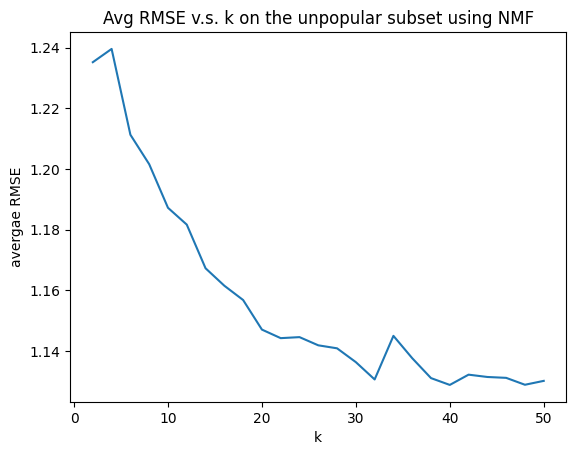

The minimum average RMSE for the unpopular subset is 1.1288989745629299 at k=40


In [ ]:
# unpopular subset
avg_RMSEs_nmf_unpopular, _ = subset_test(data_frame, "unpopular", nmf_ks, filter="NMF")
min_RMSE_nmf_unpopular = min(avg_RMSEs_nmf_unpopular)
min_RMSE_nmf_unpopular_k = nmf_ks[avg_RMSEs_nmf_unpopular.index(min_RMSE_nmf_unpopular)]

plt.plot(nmf_ks, avg_RMSEs_nmf_unpopular)
plt.xlabel("k")
plt.ylabel("avergae RMSE")
plt.title("Avg RMSE v.s. k on the unpopular subset using NMF")
plt.show()

print(f"The minimum average RMSE for the unpopular subset is {min_RMSE_nmf_unpopular} at k={min_RMSE_nmf_unpopular_k}")

  0%|          | 0/25 [00:00<?, ?it/s]

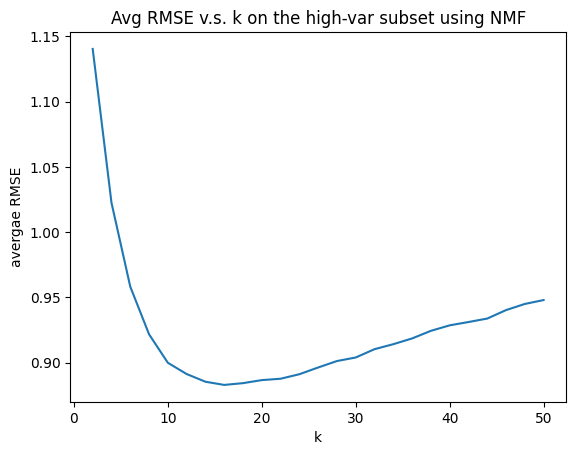

The minimum average RMSE for the high-var subset is 0.8830145317086519 at k=16


In [ ]:
# high-var subset
avg_RMSEs_nmf_highvar, _ = subset_test(data_frame, "high-var", nmf_ks, filter="NMF")
min_RMSE_nmf_highvar = min(avg_RMSEs_nmf_highvar)
min_RMSE_nmf_highvar_k = nmf_ks[avg_RMSEs_nmf_highvar.index(min_RMSE_nmf_highvar)]

plt.plot(nmf_ks, avg_RMSEs_nmf_highvar)
plt.xlabel("k")
plt.ylabel("avergae RMSE")
plt.title("Avg RMSE v.s. k on the high-var subset using NMF")
plt.show()

print(f"The minimum average RMSE for the high-var subset is {min_RMSE_nmf_highvar} at k={min_RMSE_nmf_highvar_k}")

### ROC and AUC analysis 

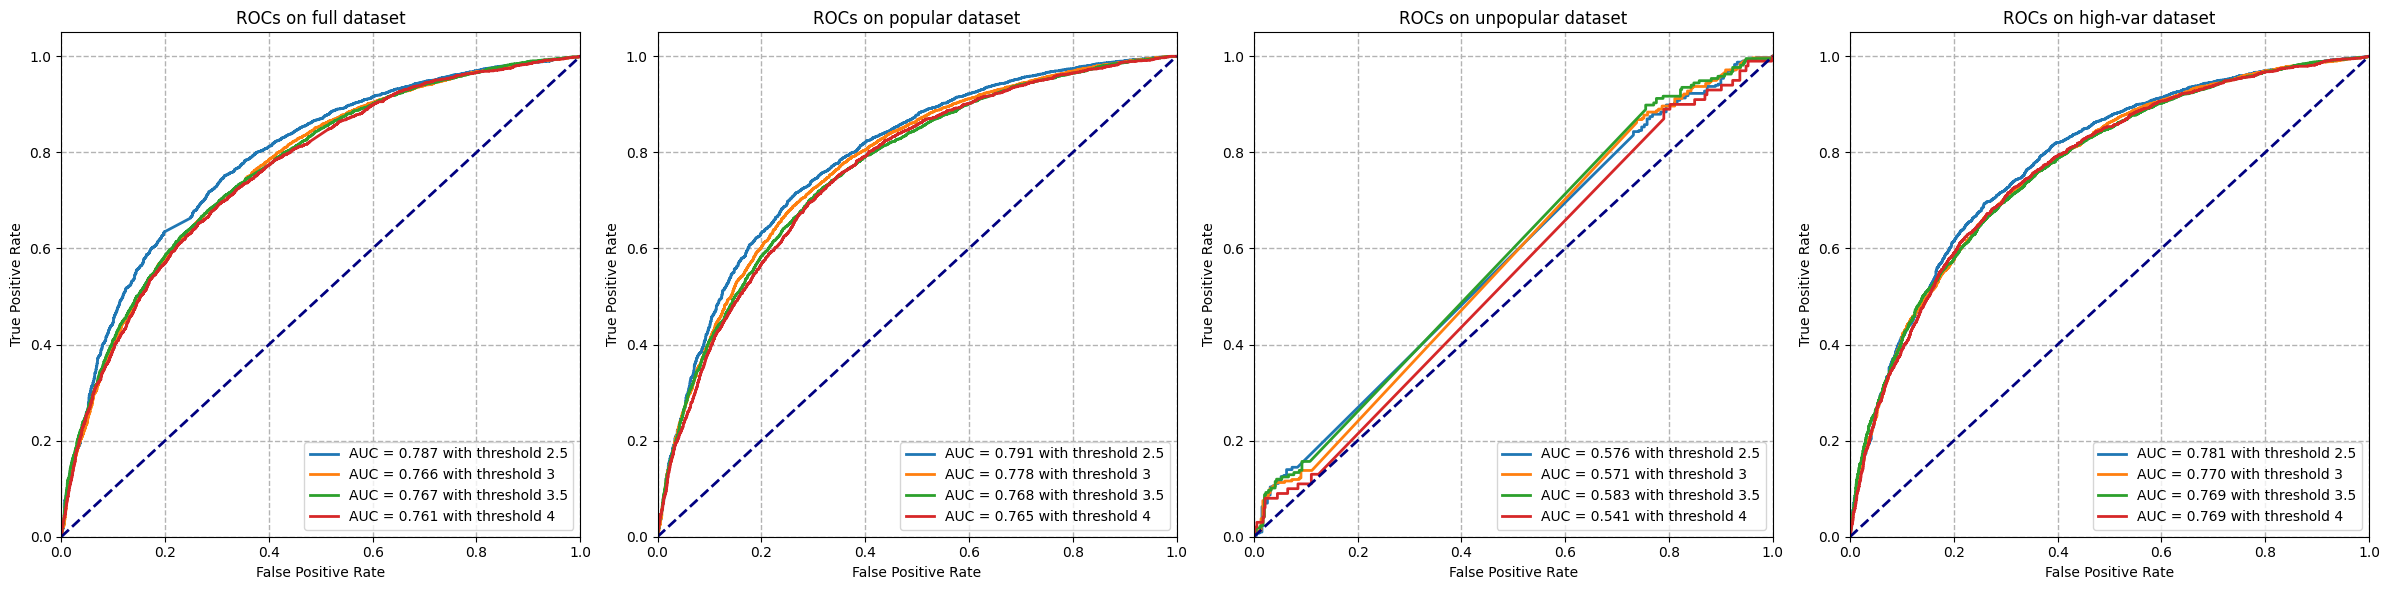

In [ ]:
# plot the ROC
thresholds = [2.5, 3, 3.5, 4]
trim_modes = ["full", "popular", "unpopular", "high-var"]
optimal_ks_nmf = {
    "full": 20,
    "popular": 16,
    "unpopular": 40,
    "high-var": 16
}

plot_pesudo_ROC(data_frame, knn_thresholds, trim_modes, optimal_ks_nmf, "NMF")

### Interpretation of NMF

In [ ]:
nmf = NMF(n_factors=20)
full_dataset = Dataset.load_from_df(data_frame[['userId', 'movieId', 'rating']], Reader(rating_scale=(0.5, 5)))
nmf.fit(full_dataset.build_full_trainset())         # fit can only work on an object of Trainset
item_features = nmf.qi                              # obtain the V matrix
sorted_item_index = np.argsort(item_features, axis=0)[:, ::-1]       # sort each column

# read the genre data
genres_df = pd.read_csv("movie_data/movies.csv")

In [ ]:
def extract_top_genres(data_df, genre_df, column_index, sorted_index, top_k=10):
    top10_index = sorted_index[:10, column_index]
    # we only have the indices right now, convert to movieId
    top10_ids = data_df.iloc[top10_index]['movieId']
    return genre_df[genre_df['movieId'].isin(top10_ids)]

In [ ]:
extract_top_genres(data_frame, genres_df, 3, sorted_item_index)

,movieId,title,genres
1275,1690,Alien: Resurrection (1997),Action|Horror|Sci-Fi
1617,2161,"NeverEnding Story, The (1984)",Adventure|Children|Fantasy
1939,2571,"Matrix, The (1999)",Action|Sci-Fi|Thriller
2259,2997,Being John Malkovich (1999),Comedy|Drama|Fantasy
3574,4896,Harry Potter and the Sorcerer's Stone (a.k.a. ...,Adventure|Children|Fantasy
4201,6063,May (2002),Drama|Horror
4867,7293,50 First Dates (2004),Comedy|Romance
5260,8636,Spider-Man 2 (2004),Action|Adventure|Sci-Fi|IMAX
6797,60684,Watchmen (2009),Action|Drama|Mystery|Sci-Fi|Thriller|IMAX
8689,122900,Ant-Man (2015),Action|Adventure|Sci-Fi


The column with index=3 have top-10 movies of genres common in "Adventure", "Action".

In [ ]:
extract_top_genres(data_frame, genres_df, 6, sorted_item_index)

,movieId,title,genres
211,247,Heavenly Creatures (1994),Crime|Drama
1231,1639,Chasing Amy (1997),Comedy|Drama|Romance
1331,1801,"Man in the Iron Mask, The (1998)",Action|Adventure|Drama
1622,2166,Return to Paradise (1998),Crime|Drama|Romance|Thriller
2156,2871,Deliverance (1972),Adventure|Drama|Thriller
2589,3461,Lord of the Flies (1963),Adventure|Drama|Thriller
3624,4975,Vanilla Sky (2001),Mystery|Romance|Sci-Fi|Thriller
6985,66934,Dr. Horrible's Sing-Along Blog (2008),Comedy|Drama|Musical|Sci-Fi
7198,72641,"Blind Side, The (2009)",Drama
7463,81819,Biutiful (2010),Drama


The column with index=6 have top-10 movies of genres common in "Thriller" and "Drama".

In [ ]:
extract_top_genres(data_frame, genres_df, 15, sorted_item_index)

,movieId,title,genres
378,434,Cliffhanger (1993),Action|Adventure|Thriller
514,597,Pretty Woman (1990),Comedy|Romance
1275,1690,Alien: Resurrection (1997),Action|Horror|Sci-Fi
1320,1779,Sphere (1998),Sci-Fi|Thriller
3141,4226,Memento (2000),Mystery|Thriller
3436,4681,"War of the Roses, The (1989)",Comedy|Drama
3640,4995,"Beautiful Mind, A (2001)",Drama|Romance
4758,7084,"Play It Again, Sam (1972)",Comedy|Romance
6694,58295,"Bank Job, The (2008)",Action|Crime|Thriller
6725,58998,Forgetting Sarah Marshall (2008),Comedy|Romance


The column with index=18 have top-10 movies of genres common in "Romance".

There is a tight connection between the latent factors and the movie genres. We could see from the experiments above that one latent factor corresponds to a small set of genres of the movies.

## MF with bias

### MF-bias over 10-fold cross-validation 

In [ ]:
mf_bias_ks = [k for k in range(2, 52, 2)]

  0%|          | 0/25 [00:00<?, ?it/s]

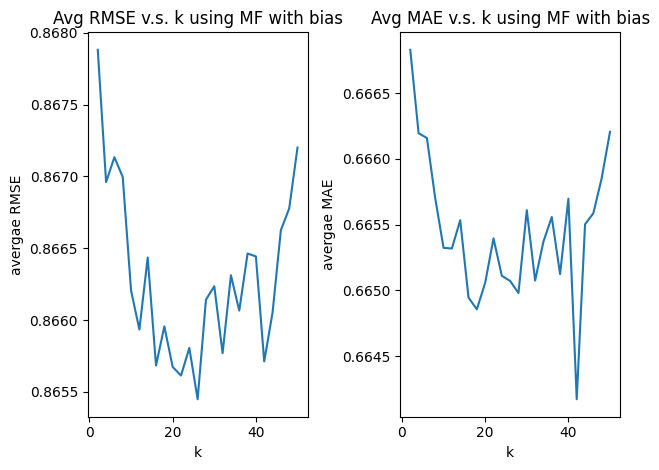

In [ ]:
avg_RMSEs_mf_bias_full, avg_MAEs_mf_bias_full = subset_test(data_frame, "full", mf_bias_ks, filter="MF-bias")

plt.subplot(1, 2, 1)
plt.plot(mf_bias_ks, avg_RMSEs_mf_bias_full)
plt.xlabel("k")
plt.ylabel("avergae RMSE")
plt.title("Avg RMSE v.s. k using MF with bias")

plt.subplot(1, 2, 2)
plt.plot(mf_bias_ks, avg_MAEs_mf_bias_full)
plt.xlabel("k")
plt.ylabel("avergae MAE")
plt.title("Avg MAE v.s. k using MF with bias")

plt.tight_layout()
plt.show()

### Optimal number of latent factors 

In [ ]:
min_RMSE_mf_bias_full = min(avg_RMSEs_mf_bias_full)
min_RMSE_mf_bias_full_k = mf_bias_ks[avg_RMSEs_mf_bias_full.index(min_RMSE_mf_bias_full)]
print(f"Min average RMSE is {min_RMSE_mf_bias_full} when the number of factors is {min_RMSE_mf_bias_full_k}")

min_MAE_mf_bias_full = min(avg_MAEs_mf_bias_full)
min_MAE_mf_bias_full_k = mf_bias_ks[avg_MAEs_mf_bias_full.index(min_MAE_mf_bias_full)]
print(f"Min average MAE is {min_MAE_mf_bias_full} when the number of factors is {min_MAE_mf_bias_full_k}")

Min average RMSE is 0.8654480897867511 when the number of factors is 26
Min average MAE is 0.6641715950372254 when the number of factors is 42


The optimal k above should be 30 or 40, which is far away from the number of movie genres (19).

### Trim subsets

  0%|          | 0/25 [00:00<?, ?it/s]

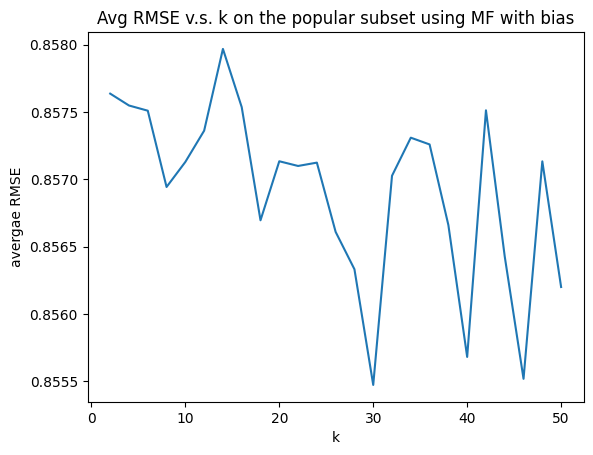

The minimum average RMSE for the popular subset is 0.8554717762703772 at k=30


In [ ]:
# popular subset
avg_RMSEs_mf_bias_popular, _ = subset_test(data_frame, "popular", mf_bias_ks, filter="MF-bias")
min_RMSE_mf_bias_popular = min(avg_RMSEs_mf_bias_popular)
min_RMSE_mf_bias_popular_k = mf_bias_ks[avg_RMSEs_mf_bias_popular.index(min_RMSE_mf_bias_popular)]

plt.plot(mf_bias_ks, avg_RMSEs_mf_bias_popular)
plt.xlabel("k")
plt.ylabel("avergae RMSE")
plt.title("Avg RMSE v.s. k on the popular subset using MF with bias")
plt.show()

print(f"The minimum average RMSE for the popular subset is {min_RMSE_mf_bias_popular} at k={min_RMSE_mf_bias_popular_k}")

  0%|          | 0/25 [00:00<?, ?it/s]

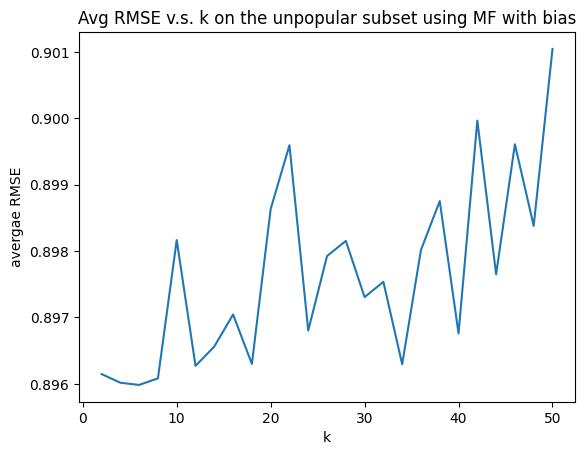

The minimum average RMSE for the unpopular subset is 0.8959839821813054 at k=6


In [ ]:
# unpopular subset
avg_RMSEs_mf_bias_unpopular, _ = subset_test(data_frame, "unpopular", mf_bias_ks, filter="MF-bias")
min_RMSE_mf_bias_unpopular = min(avg_RMSEs_mf_bias_unpopular)
min_RMSE_mf_bias_unpopular_k = mf_bias_ks[avg_RMSEs_mf_bias_unpopular.index(min_RMSE_mf_bias_unpopular)]

plt.plot(mf_bias_ks, avg_RMSEs_mf_bias_unpopular)
plt.xlabel("k")
plt.ylabel("avergae RMSE")
plt.title("Avg RMSE v.s. k on the unpopular subset using MF with bias")
plt.show()

print(f"The minimum average RMSE for the unpopular subset is {min_RMSE_mf_bias_unpopular} at k={min_RMSE_mf_bias_unpopular_k}")

  0%|          | 0/25 [00:00<?, ?it/s]

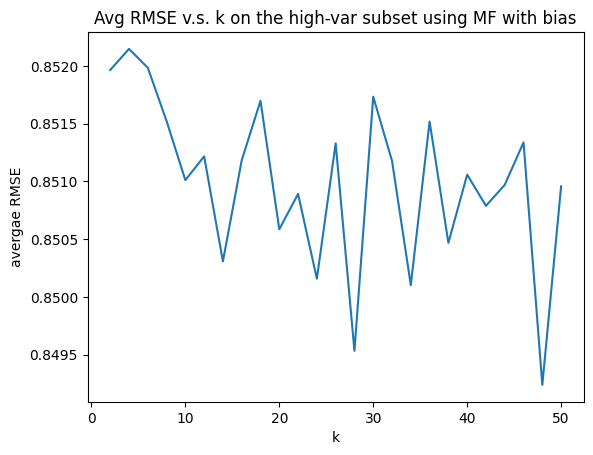

The minimum average RMSE for the high-var subset is 0.8492369151495845 at k=48


In [ ]:
# high-var subset
avg_RMSEs_mf_bias_highvar, _ = subset_test(data_frame, "high-var", mf_bias_ks, filter="MF-bias")
min_RMSE_mf_bias_highvar = min(avg_RMSEs_mf_bias_highvar)
min_RMSE_mf_bias_highvar_k = mf_bias_ks[avg_RMSEs_mf_bias_highvar.index(min_RMSE_mf_bias_highvar)]

plt.plot(mf_bias_ks, avg_RMSEs_mf_bias_highvar)
plt.xlabel("k")
plt.ylabel("avergae RMSE")
plt.title("Avg RMSE v.s. k on the high-var subset using MF with bias")
plt.show()

print(f"The minimum average RMSE for the high-var subset is {min_RMSE_mf_bias_highvar} at k={min_RMSE_mf_bias_highvar_k}")

### ROC and AUC analysis 

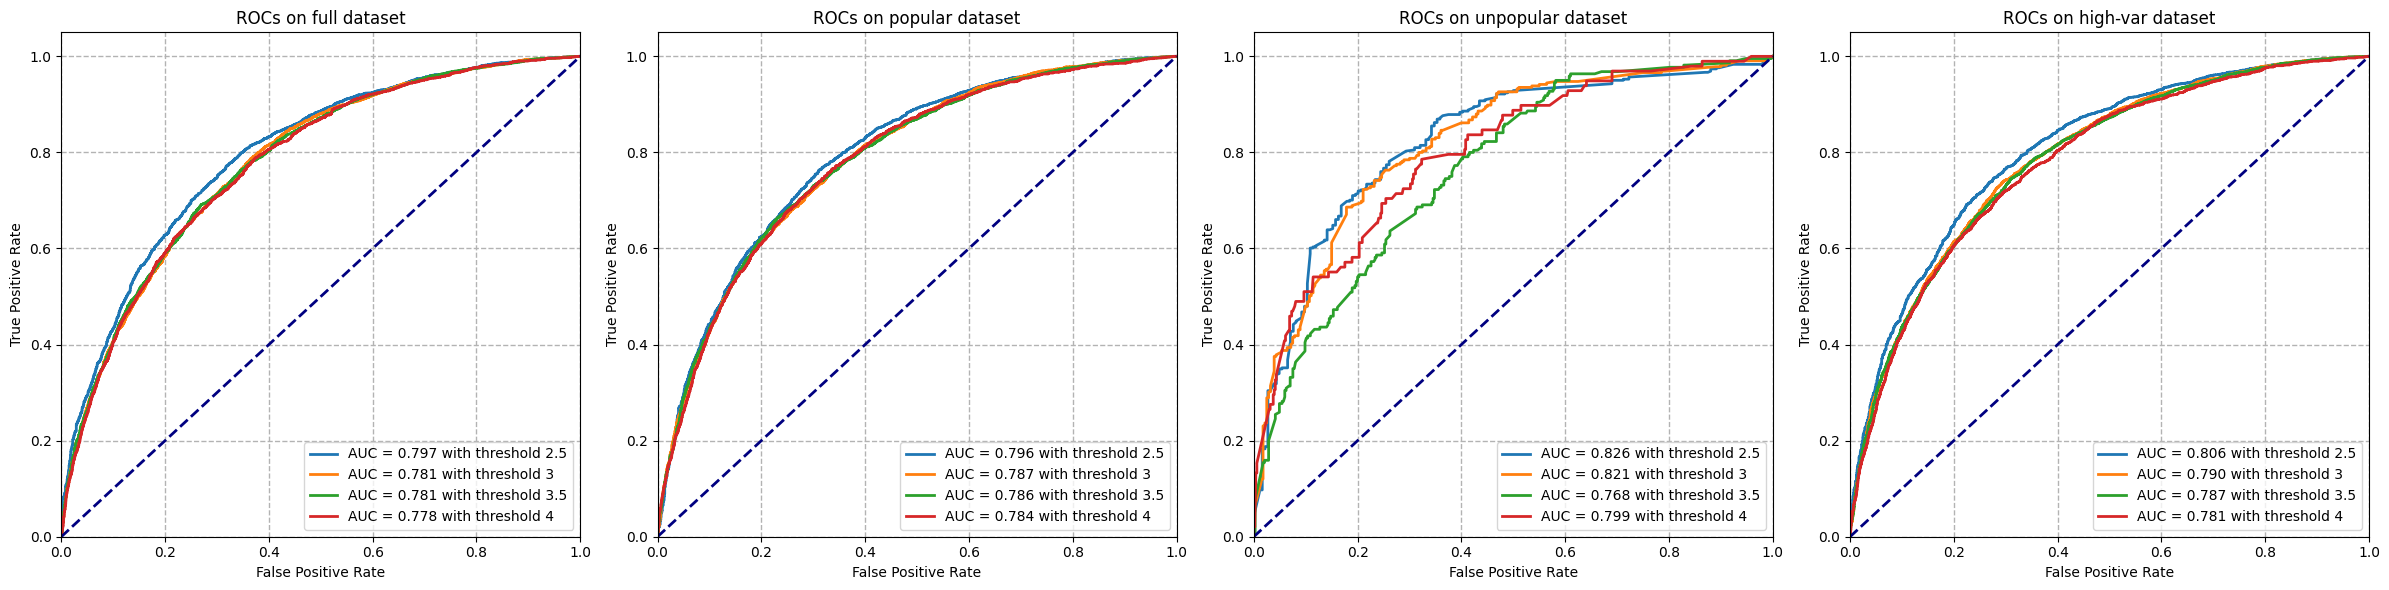

In [ ]:
# plot the ROC
thresholds = [2.5, 3, 3.5, 4]
trim_modes = ["full", "popular", "unpopular", "high-var"]
optimal_ks_mf_bias = {
    "full": 40,
    "popular": 30,
    "unpopular": 6,
    "high-var": 48
}

plot_pesudo_ROC(data_frame, knn_thresholds, trim_modes, optimal_ks_nmf, "MF-bias")

## Naive collaborative filter

In [ ]:
avg_RMSE_naive_full = subset_naive(data_frame, "full")
print(f"The average RMSE on the full dataset using naive method is {avg_RMSE_naive_full}")

The average RMSE on the full dataset using naive method is 0.9347086488068349


In [ ]:
avg_RMSE_naive_popular = subset_naive(data_frame, "popular")
print(f"The average RMSE on the popular dataset for naive method is {avg_RMSE_naive_popular}")

The average RMSE on the popular dataset for naive method is 0.9307615956330867


In [ ]:
avg_RMSE_naive_unpopular = subset_naive(data_frame, "unpopular")
print(f"The average RMSE on the popular dataset for naive method is {avg_RMSE_naive_unpopular}")

The average RMSE on the popular dataset for naive method is 0.8405618725327484


In [ ]:
avg_RMSE_naive_high_var = subset_naive(data_frame, "high-var")
print(f"The average RMSE on the high-var dataset for naive method is {avg_RMSE_naive_high_var}")

The average RMSE on the high-var dataset for naive method is 0.9266963397377881


## Comparison

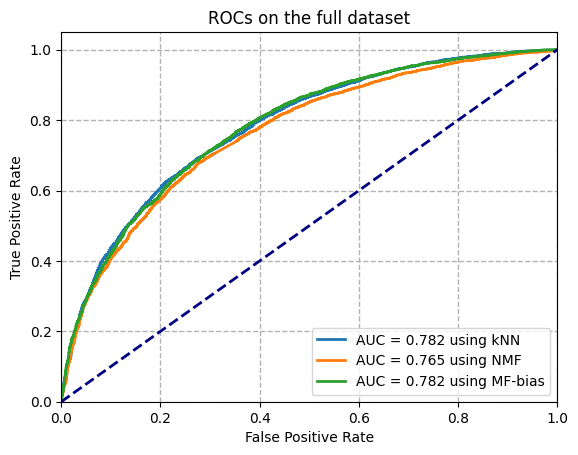

In [ ]:
threshold = 3
optimal_ks = {
    "kNN": 24,
    "NMF": 20,
    "MF-bias": 20
}
types = ["kNN", "NMF", "MF-bias"]

# convert the original dataframe into a surprise dataset
full_data = Dataset.load_from_df(data_frame[['userId', 'movieId', 'rating']], Reader(rating_scale=(0.5, 5)))
optimal_knn = KNNWithMeans(k=optimal_ks["kNN"], sim_options={"name": "pearson", "user_based": True}, verbose=False)
optimal_nmf = NMF(n_factors=optimal_ks["NMF"])
optimal_mf_bias = SVD(n_factors=optimal_ks["MF-bias"])

# split into 90% training and 10% validation
train, val = train_test_split(full_data, test_size=0.1)
# train the models
optimal_knn.fit(train)
optimal_nmf.fit(train)
optimal_mf_bias.fit(train)
# test on the validation subset
preds_knn = optimal_knn.test(val)
preds_nmf = optimal_nmf.test(val)
preds_mf_bias = optimal_mf_bias.test(val)
preds_lst = [preds_knn, preds_nmf, preds_mf_bias]

for i in range(len(preds_lst)):
    preds = preds_lst[i]
    preds_type = types[i]
    # collect the predicted and true labels after binarization by the threshold
    true_ratings = [1 if pred.r_ui > threshold else 0 for pred in preds]
    pred_ratings = [pred.est for pred in preds]
    # compute ROC and AUC
    fpr, tpr, _ = roc_curve(true_ratings, pred_ratings)
    roc_auc = auc(fpr,tpr)
    plt.plot(fpr, tpr, lw=2, label="AUC = {:.3f} using {}".format(roc_auc, preds_type))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.grid(color='0.7', linestyle='--', linewidth=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROCs on the full dataset")
plt.legend(loc="lower right")
plt.show()

From the plots above, we can see that the best model is kNN with k=24 and MF-bias with k=20 since their curves have the largest AUC. Besides, all 3 models have the similar performances so they are equally good.